In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


In [3]:
os.chdir("C:\\Users\\sudheer\\Desktop\\python projects\\Bone_Fracture_detection")
os.getcwd()

'C:\\Users\\sudheer\\Desktop\\python projects\\Bone_Fracture_detection'

In [4]:
data = "raw_data"

In [5]:

def filter_and_store_in_dataframe(base_directory):
    d = []  # List to store image and class data

    for class_name in os.listdir(base_directory):
        class_path = os.path.join(base_directory, class_name)
        
        if os.path.isdir(class_path):  # Ensure it's a folder representing a class
            for filename in os.listdir(class_path):
                image_path = os.path.join(class_path, filename)
                image= cv2.imread(image_path)
                if image is None:
                    print(f"Skipping corrupted or non-image file: {filename} in {class_name}") 
                    continue  #skip to the next image
                try:
                    #Resize image to prepered shape
                    image_re = cv2.resize(image,(224,224))
                    img_array = np.array(image_re)  #ensure img_data 
                    d.append([img_array, class_name])  # Append image and class to the list
                except Exception as e:
                    print(f"Error processing {filename}: {e}")
                    continue  # Skip any problematic image

    # Convert the list to a DataFrame
    df = pd.DataFrame(d, columns=["valid_image", "class_label"])
    return df

In [6]:
# Example usage:
image_dataframe = filter_and_store_in_dataframe(data)

Skipping corrupted or non-image file: 159.jpg in fractured
Skipping corrupted or non-image file: 2.jpg in fractured
Skipping corrupted or non-image file: 26(1).jpg in fractured


In [7]:
print(image_dataframe.head())  # Display the first few rows of the DataFrame

                                         valid_image class_label
0  [[[60, 60, 60], [59, 59, 59], [55, 55, 55], [5...   fractured
1  [[[242, 242, 242], [241, 241, 241], [245, 245,...   fractured
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   fractured
3  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...   fractured
4  [[[109, 109, 109], [111, 111, 111], [109, 109,...   fractured


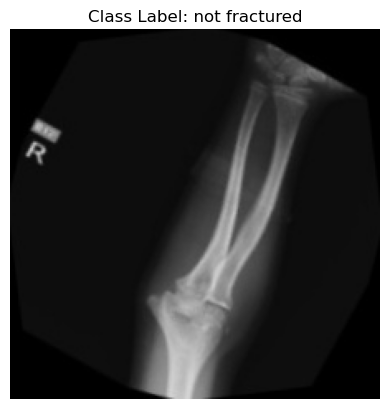

In [8]:
random_row = image_dataframe.sample(n=1).iloc[0]
image = random_row["valid_image"]
class_label = random_row["class_label"]

# Display the image and class label
plt.imshow(image)
plt.title(f"Class Label: {class_label}")
plt.axis("off")
plt.show()


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
from sklearn.model_selection import train_test_split
print(image_dataframe["class_label"].unique())  # Check class labels
# Optional: Map custom labels to binary format (if necessary)
image_dataframe["class_label"] = image_dataframe["class_label"].map({
    "fractured": 1,
    "not fractured": 0
})
print(image_dataframe["class_label"].unique()) 

['fractured' 'not fractured']
[1 0]


In [11]:
# Split the DataFrame
train_df, temp_df = train_test_split(image_dataframe, test_size=0.3, random_state=42)  # 70% train, 30% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 15% validation, 15% test

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(test_df)}")

Training samples: 6613, Validation samples: 1417, Test samples: 1418


In [12]:

def prepare_data(dataframe):
    images = np.stack(dataframe["valid_image"].values)  # Stack images into a NumPy array
    labels = dataframe["class_label"].values
    return images, labels

# Prepare datasets
x_train, y_train = prepare_data(train_df)
x_val, y_val = prepare_data(val_df)
x_test, y_test = prepare_data(test_df)

# Normalize pixel values to the range [0, 1]
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.regularizers import l2

In [14]:
Bone_fracture_model =Sequential([
          Conv2D(16,(3,3),activation= "relu",input_shape = (224,224,3),
                kernel_initializer="he_normal"),
          BatchNormalization(),
          MaxPooling2D((2,2)),
          Conv2D(32,(3,3),activation= "relu",kernel_initializer="he_normal"),
          BatchNormalization(),
          MaxPooling2D((2,2)),
          Dropout(0.3),
          Conv2D(64,(3,3),activation= "relu",kernel_initializer="he_normal"),
          BatchNormalization(), 
          MaxPooling2D((2,2)),
          Flatten(),
          Dense(128,activation= "relu",kernel_regularizer = l2(0.01),
               kernel_initializer="he_normal"),
          Dropout(0.5),
          Dense(1,activation= "sigmoid")
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
#learning rateadjustment callback
reduce_lr = ReduceLROnPlateau(
    monitor = "val_loss",  #monitor validation loss
    factor = 0.5,         #reduce learning rate by 50%
    patience = 4,         #wait for 4 epochs with no improvement
    verbose = 1,          # displays massages when learning rate is reduced
    min_lr = "0.002"       # set a lower bound for the learning rate
)

In [16]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop training if no improvement for 5 epochs
    verbose=1,           # Display messages when stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)


In [17]:
from tensorflow.keras.optimizers import Adam
from datetime import datetime

In [18]:
Bone_fracture_model.compile(
    optimizer = Adam(learning_rate= 1e-4),
    loss = "binary_crossentropy",
    metrics = ['accuracy']
)
Bone_fracture_model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
____________________________

In [19]:
# Get the current system time (only time)
start_time = datetime.now()
history = Bone_fracture_model.fit(
    x_train,y_train,
    validation_data=(x_val,y_val),
    epochs=10
    #callbacks = [early_stopping,reduce_lr]    
)
end_time = datetime.now()

Train on 6613 samples, validate on 1417 samples
Epoch 1/10
6613/6613 [==============================] - 195s 29ms/sample - loss: 2.6288 - acc: 0.8288 - val_loss: 3.0409 - val_acc: 0.6196
Epoch 2/10
6613/6613 [==============================] - 205s 31ms/sample - loss: 1.8029 - acc: 0.9279 - val_loss: 1.7346 - val_acc: 0.8560
Epoch 3/10
6613/6613 [==============================] - 157s 24ms/sample - loss: 1.3438 - acc: 0.9577 - val_loss: 1.1651 - val_acc: 0.9661
Epoch 4/10
6613/6613 [==============================] - 164s 25ms/sample - loss: 1.0258 - acc: 0.9698 - val_loss: 0.8920 - val_acc: 0.9704
Epoch 5/10
6613/6613 [==============================] - 161s 24ms/sample - loss: 0.8033 - acc: 0.9732 - val_loss: 0.7042 - val_acc: 0.9788
Epoch 6/10
6613/6613 [==============================] - 154s 23ms/sample - loss: 0.6428 - acc: 0.9770 - val_loss: 0.5702 - val_acc: 0.9824
Epoch 7/10
6613/6613 [==============================] - 159s 24ms/sample - loss: 0.5300 - acc: 0.9796 - val_loss: 0.47

In [20]:
print("time_taken:",end_time-start_time) 

time_taken: 0:27:47.345200


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [22]:
test_loss, test_accuracy = Bone_fracture_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1418/1418 [==============================] - 18s 13ms/sample - loss: 0.3114 - acc: 0.9880
Test Accuracy: 98.80%


In [24]:
predictions = Bone_fracture_model.predict(x_test)
binary_predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

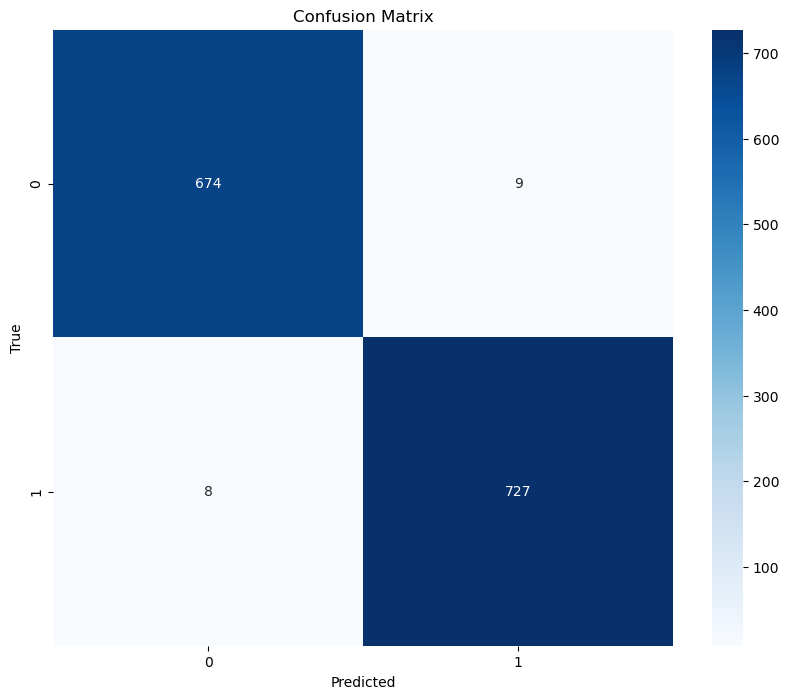

In [28]:
cm = confusion_matrix(y_test, binary_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
